## K means


In [0]:
#!pip install dgl


In [4]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm


In [3]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import math
import dgl
from collections import Counter
import performance as pf

# Test with small size: Karata Dataset

In [1]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [5]:
G = build_karate_club_graph()

In [6]:
G.number_of_nodes()

34

In [7]:
import numpy
matrix_all = numpy.empty((G.number_of_nodes(), G.number_of_nodes()))  

In [8]:
matrix = G.adjacency_matrix()

C:\Users\Robert\Anaconda3\lib\site-packages\dgl\base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [9]:
matrix = matrix.to_dense()

In [10]:
#Distance measure Burt, 1976 in 04_2010
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = 0
        for n in range(n_nodes):          
            x += int((matrix[i][n]-matrix[j][n]))**2
            
        matrix_all[i][j] = math.sqrt(x)    
        #print (math.sqrt(x))

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 62.80it/s]


In [11]:
import numpy as np
from scipy import sparse

def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs.item(1)

In [12]:
#Distance measure pearson correlation
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = sparse_corrcoef(matrix[i],matrix[j])
        matrix_all[i][j] = x    
        #print (math.sqrt(x))

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 46.51it/s]


In [13]:
from sklearn.cluster import KMeans
import numpy as np
X = matrix_all
kmeans = KMeans(n_clusters=2,n_init=10,max_iter=10000).fit(X)
#kmeans.labels_
#kmeans.cluster_centers_

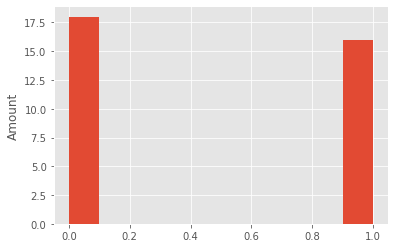

In [14]:
#Distribution of lables
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
x = kmeans.labels_
plt.hist(x)
plt.ylabel('Amount');

In [15]:
kinda_true_labels = [0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
import performance as pf

In [17]:
pf.rand_score(kinda_true_labels,kmeans.labels_)

0.6681803438209536

In [18]:
pf.mutual_info_score(kinda_true_labels,kmeans.labels_)

0.5659095762420082

In [19]:
pf.variation_of_information_score(kinda_true_labels,kmeans.labels_)

0.58765973614411

# Cora

In [116]:
from dgl import DGLGraph
from dgl.data import CoraFull

In [117]:
data = citegrh.load_cora()
G = DGLGraph(data.graph)

In [118]:
G

DGLGraph(num_nodes=2708, num_edges=10556,
         ndata_schemes={}
         edata_schemes={})

In [119]:
matrix = G.adjacency_matrix()

C:\Users\Robert\Anaconda3\lib\site-packages\dgl\base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


## K-means on features

In [240]:
import torch as th
features = th.FloatTensor(data.features)

In [241]:
features.shape

torch.Size([2708, 1433])

In [291]:
from sklearn.cluster import KMeans
import performance as pf
import numpy as np
best_rand = 0
best_mi = 0
best_voi = 0
for a in range(50):
    X = features
    kmeans = KMeans(n_clusters=7, max).fit(X)
    if pf.rand_score(data.labels,kmeans.labels_) > best_rand :
        best_rand = pf.rand_score(data.labels,kmeans.labels_)
    if pf.mutual_info_score(data.labels,kmeans.labels_) > best_mi:
        best_mi = pf.mutual_info_score(data.labels,kmeans.labels_ )                                
    if pf.variation_of_information_score(data.labels,kmeans.labels_) > best_voi:
        best_voi = pf.variation_of_information_score(data.labels,kmeans.labels_)                           

In [292]:
print(best_rand,best_mi,best_voi)

0.10554589743118742 0.18602362464886696 3.1533263511927023


In [312]:
from sklearn.cluster import KMeans
import performance as pf
import numpy as np
best_rand = 0
best_mi = 0
best_voi = 0
for a in range(50):
    X = features
    kmeans = KMeans(n_clusters=7, max_iter=3000).fit(X)
    if pf.rand_score(data.labels,kmeans.labels_) > best_rand :
        best_rand = pf.rand_score(data.labels,kmeans.labels_)
    if pf.mutual_info_score(data.labels,kmeans.labels_) > best_mi:
        best_mi = pf.mutual_info_score(data.labels,kmeans.labels_ )                                
    if pf.variation_of_information_score(data.labels,kmeans.labels_) > best_voi:
        best_voi = pf.variation_of_information_score(data.labels,kmeans.labels_) 

In [313]:
print(best_rand,best_mi,best_voi)

0.11275742023957126 0.21500421033802902 3.1854924417452457


## K-means on features with prior PCA

In [305]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(features)
pca = PCA(n_components=20)
pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.02922788 0.02212903 0.02080279 0.01641119 0.01358666 0.01301004
 0.01083892 0.00967664 0.0086494  0.00790825 0.0077169  0.00750114
 0.00724665 0.00695494 0.00688562 0.00677817 0.00659552 0.00643459
 0.00610373 0.00607969]
[2.343446  2.0390954 1.9770473 1.7560073 1.5977643 1.563492  1.4270833
 1.3483998 1.2748213 1.2189798 1.2041419 1.1871891 1.1668764 1.1431494
 1.1374383 1.1285282 1.1132191 1.0995542 1.070912  1.0688012]


In [306]:
pca_values = pca.transform(features)

In [307]:
pca_values[0]

array([-0.02803252, -0.0229243 , -0.00520735,  0.05092381, -0.01155104,
       -0.00013121, -0.00096232,  0.01683409, -0.01224639, -0.0114224 ,
       -0.02710062,  0.03344807,  0.00670685, -0.00089468,  0.00288493,
        0.00534375,  0.01000094, -0.00181575, -0.00751777,  0.0057508 ],
      dtype=float32)

In [308]:
from sklearn.cluster import KMeans
import numpy as np
best_rand = 0
best_mi = 0
best_voi = 0
for a in range(50):
    X = pca_values
    kmeans = KMeans(n_clusters=7).fit(X)
    if pf.rand_score(data.labels,kmeans.labels_) > best_rand :
        best_rand = pf.rand_score(data.labels,kmeans.labels_)
    if pf.mutual_info_score(data.labels,kmeans.labels_) > best_mi:
        best_mi = pf.mutual_info_score(data.labels,kmeans.labels_ )                                
    if pf.variation_of_information_score(data.labels,kmeans.labels_) > best_voi:
        best_voi = pf.variation_of_information_score(data.labels,kmeans.labels_)   

In [309]:
print(best_rand,best_mi,best_voi)

0.06672588705894548 0.1365756677855395 3.071380756663525


## K-means on adjacency matrix

In [310]:
from sklearn.cluster import KMeans
import numpy as np
X = matrix.to_dense()
best_rand = 0
best_mi = 0
best_voi = 0
for a in range(50):
    kmeans = KMeans(n_clusters=7).fit(X)
    if pf.rand_score(data.labels,kmeans.labels_) > best_rand :
        best_rand = pf.rand_score(data.labels,kmeans.labels_)
    if pf.mutual_info_score(data.labels,kmeans.labels_) > best_mi:
        best_mi = pf.mutual_info_score(data.labels,kmeans.labels_ )                                
    if pf.variation_of_information_score(data.labels,kmeans.labels_) > best_voi:
        best_voi = pf.variation_of_information_score(data.labels,kmeans.labels_)  

In [311]:
print(best_rand,best_mi,best_voi)

0.04540412755209075 0.1620239460995283 2.0422114755541907


## Dimensionality reduction on (sparse) adjacency matrix

In [150]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(matrix.to_dense())
pca = PCA(n_components=5)
pca.fit_transform(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)


[0.0187649  0.01435182 0.01237287 0.00874205 0.00790466]
[14.045742 12.283581 11.405302  9.586898  9.116187]


In [151]:
pca.components_.transpose()

array([[-0.00179361,  0.00117074, -0.00267214, -0.00242185,  0.00290017],
       [-0.00050636,  0.00045809, -0.00073824, -0.00117733,  0.00179404],
       [-0.00059215,  0.01137699,  0.0769325 , -0.00369702,  0.03287299],
       ...,
       [ 0.00339101, -0.00357114, -0.0006586 , -0.00075266,  0.00083535],
       [-0.00113422,  0.00071024, -0.00140521, -0.00154561,  0.00164815],
       [-0.00084397,  0.00051202, -0.00103965, -0.00059495,  0.00110155]],
      dtype=float32)

In [152]:
import pandas as pd

def standardize(df):
    result = df.copy()
    for feature_name in df.columns:
        std = np.std(df[feature_name])
        mean = np.mean(df[feature_name])
        result[feature_name] = (df[feature_name] - mean) / std
    return result

In [153]:
pca_values = pca.components_.transpose()
pca_values_std = standardize(pd.DataFrame(pca_values))

In [154]:
from sklearn.cluster import KMeans
import numpy as np
X = pca_values_std
kmeans = KMeans(n_clusters=7).fit(X)
#kmeans.labels_
#kmeans.cluster_centers_

In [155]:
kmeans.labels_

array([0, 0, 6, ..., 0, 0, 0])

In [156]:
import performance as pf

In [157]:
pf.rand_score(data.labels,kmeans.labels_)

0.019733451908450727

In [158]:
pf.mutual_info_score(data.labels,kmeans.labels_)

0.16355874162929465

In [159]:
pf.variation_of_information_score(data.labels,kmeans.labels_)

1.9954791897361

## Using distance measures

In [ ]:
matrix = G.adjacency_matrix()

In [130]:
import numpy as np
from scipy import sparse

def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs.item(1)

In [131]:
matrix_dense = matrix.to_dense()

In [132]:
import numpy
matrix_all = numpy.empty((G.number_of_nodes(), G.number_of_nodes()))  

In [136]:
#Distance measure pearson corr
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = sparse_corrcoef(matrix_dense[i],matrix_dense[j])
        matrix_all[i][j] = x    
        #print (math.sqrt(x))






  0%|                                                                                         | 0/2708 [00:00<?, ?it/s]




  0%|                                                                               | 1/2708 [00:01<1:27:34,  1.94s/it]




  0%|                                                                               | 2/2708 [00:03<1:25:52,  1.90s/it]




  0%|                                                                               | 3/2708 [00:05<1:23:54,  1.86s/it]




  0%|                                                                               | 4/2708 [00:07<1:24:41,  1.88s/it]




  0%|▏                                                                              | 5/2708 [00:09<1:23:52,  1.86s/it]




  0%|▏                                                                              | 6/2708 [00:11<1:24:41,  1.88s/it]




  0%|▏                                                                              | 7/2708 [00:12<1:23:42,  1.86s/it]




  0

  5%|███▊                                                                         | 132/2708 [04:02<1:18:30,  1.83s/it]




  5%|███▊                                                                         | 133/2708 [04:04<1:17:46,  1.81s/it]




  5%|███▊                                                                         | 134/2708 [04:06<1:18:25,  1.83s/it]




  5%|███▊                                                                         | 135/2708 [04:08<1:19:16,  1.85s/it]




  5%|███▊                                                                         | 136/2708 [04:10<1:22:20,  1.92s/it]




  5%|███▉                                                                         | 137/2708 [04:12<1:24:14,  1.97s/it]




  5%|███▉                                                                         | 138/2708 [04:14<1:22:11,  1.92s/it]




  5%|███▉                                                                         | 139/2708 [04:16<1:20:40,  1.88s/it]




  5%|███

 10%|███████▌                                                                     | 264/2708 [08:02<1:12:38,  1.78s/it]




 10%|███████▌                                                                     | 265/2708 [08:04<1:13:26,  1.80s/it]




 10%|███████▌                                                                     | 266/2708 [08:05<1:14:05,  1.82s/it]




 10%|███████▌                                                                     | 267/2708 [08:07<1:13:39,  1.81s/it]




 10%|███████▌                                                                     | 268/2708 [08:09<1:12:52,  1.79s/it]




 10%|███████▋                                                                     | 269/2708 [08:11<1:12:27,  1.78s/it]




 10%|███████▋                                                                     | 270/2708 [08:13<1:12:05,  1.77s/it]




 10%|███████▋                                                                     | 271/2708 [08:14<1:11:54,  1.77s/it]




 10%|███

 15%|███████████▎                                                                 | 396/2708 [12:16<1:20:21,  2.09s/it]




 15%|███████████▎                                                                 | 397/2708 [12:18<1:17:14,  2.01s/it]




 15%|███████████▎                                                                 | 398/2708 [12:20<1:19:26,  2.06s/it]




 15%|███████████▎                                                                 | 399/2708 [12:23<1:23:05,  2.16s/it]




 15%|███████████▎                                                                 | 400/2708 [12:25<1:21:56,  2.13s/it]




 15%|███████████▍                                                                 | 401/2708 [12:27<1:19:40,  2.07s/it]




 15%|███████████▍                                                                 | 402/2708 [12:29<1:19:39,  2.07s/it]




 15%|███████████▍                                                                 | 403/2708 [12:31<1:19:58,  2.08s/it]




 15%|███

 19%|███████████████                                                              | 528/2708 [16:49<1:07:21,  1.85s/it]




 20%|███████████████                                                              | 529/2708 [16:50<1:06:40,  1.84s/it]




 20%|███████████████                                                              | 530/2708 [16:52<1:06:42,  1.84s/it]




 20%|███████████████                                                              | 531/2708 [16:54<1:06:33,  1.83s/it]




 20%|███████████████▏                                                             | 532/2708 [16:56<1:07:56,  1.87s/it]




 20%|███████████████▏                                                             | 533/2708 [16:58<1:08:49,  1.90s/it]




 20%|███████████████▏                                                             | 534/2708 [17:00<1:08:40,  1.90s/it]




 20%|███████████████▏                                                             | 535/2708 [17:02<1:08:55,  1.90s/it]




 20%|███

 24%|███████████████████▎                                                           | 660/2708 [20:42<59:34,  1.75s/it]




 24%|███████████████████▎                                                           | 661/2708 [20:44<59:28,  1.74s/it]




 24%|███████████████████▎                                                           | 662/2708 [20:46<59:27,  1.74s/it]




 24%|███████████████████▎                                                           | 663/2708 [20:47<59:27,  1.74s/it]




 25%|██████████████████▉                                                          | 664/2708 [20:49<1:00:10,  1.77s/it]




 25%|██████████████████▉                                                          | 665/2708 [20:51<1:00:44,  1.78s/it]




 25%|██████████████████▉                                                          | 666/2708 [20:53<1:02:03,  1.82s/it]




 25%|██████████████████▉                                                          | 667/2708 [20:55<1:02:57,  1.85s/it]




 25%|███

 29%|███████████████████████                                                        | 792/2708 [24:35<55:57,  1.75s/it]




 29%|███████████████████████▏                                                       | 793/2708 [24:37<55:50,  1.75s/it]




 29%|███████████████████████▏                                                       | 794/2708 [24:38<55:50,  1.75s/it]




 29%|███████████████████████▏                                                       | 795/2708 [24:40<55:42,  1.75s/it]




 29%|███████████████████████▏                                                       | 796/2708 [24:42<55:38,  1.75s/it]




 29%|███████████████████████▎                                                       | 797/2708 [24:44<55:34,  1.75s/it]




 29%|███████████████████████▎                                                       | 798/2708 [24:45<55:40,  1.75s/it]




 30%|███████████████████████▎                                                       | 799/2708 [24:47<55:36,  1.75s/it]




 30%|███

 34%|██████████████████████████▉                                                    | 924/2708 [28:27<51:55,  1.75s/it]




 34%|██████████████████████████▉                                                    | 925/2708 [28:29<51:54,  1.75s/it]




 34%|███████████████████████████                                                    | 926/2708 [28:30<52:31,  1.77s/it]




 34%|███████████████████████████                                                    | 927/2708 [28:32<53:27,  1.80s/it]




 34%|███████████████████████████                                                    | 928/2708 [28:34<54:11,  1.83s/it]




 34%|███████████████████████████                                                    | 929/2708 [28:36<53:29,  1.80s/it]




 34%|███████████████████████████▏                                                   | 930/2708 [28:38<53:05,  1.79s/it]




 34%|███████████████████████████▏                                                   | 931/2708 [28:39<52:39,  1.78s/it]




 34%|███

 39%|██████████████████████████████▍                                               | 1056/2708 [32:19<48:07,  1.75s/it]




 39%|██████████████████████████████▍                                               | 1057/2708 [32:21<48:03,  1.75s/it]




 39%|██████████████████████████████▍                                               | 1058/2708 [32:23<48:02,  1.75s/it]




 39%|██████████████████████████████▌                                               | 1059/2708 [32:24<47:59,  1.75s/it]




 39%|██████████████████████████████▌                                               | 1060/2708 [32:26<47:54,  1.74s/it]




 39%|██████████████████████████████▌                                               | 1061/2708 [32:28<47:56,  1.75s/it]




 39%|██████████████████████████████▌                                               | 1062/2708 [32:30<47:53,  1.75s/it]




 39%|██████████████████████████████▌                                               | 1063/2708 [32:31<47:59,  1.75s/it]




 39%|███

 44%|██████████████████████████████████▏                                           | 1188/2708 [36:11<45:47,  1.81s/it]




 44%|██████████████████████████████████▏                                           | 1189/2708 [36:13<46:15,  1.83s/it]




 44%|██████████████████████████████████▎                                           | 1190/2708 [36:15<46:32,  1.84s/it]




 44%|██████████████████████████████████▎                                           | 1191/2708 [36:17<45:44,  1.81s/it]




 44%|██████████████████████████████████▎                                           | 1192/2708 [36:19<45:11,  1.79s/it]




 44%|██████████████████████████████████▎                                           | 1193/2708 [36:20<44:49,  1.78s/it]




 44%|██████████████████████████████████▍                                           | 1194/2708 [36:22<44:30,  1.76s/it]




 44%|██████████████████████████████████▍                                           | 1195/2708 [36:24<44:19,  1.76s/it]




 44%|███

 49%|██████████████████████████████████████                                        | 1320/2708 [40:04<40:29,  1.75s/it]




 49%|██████████████████████████████████████                                        | 1321/2708 [40:06<40:23,  1.75s/it]




 49%|██████████████████████████████████████                                        | 1322/2708 [40:07<40:20,  1.75s/it]




 49%|██████████████████████████████████████                                        | 1323/2708 [40:09<40:16,  1.74s/it]




 49%|██████████████████████████████████████▏                                       | 1324/2708 [40:11<40:13,  1.74s/it]




 49%|██████████████████████████████████████▏                                       | 1325/2708 [40:13<40:11,  1.74s/it]




 49%|██████████████████████████████████████▏                                       | 1326/2708 [40:14<40:09,  1.74s/it]




 49%|██████████████████████████████████████▏                                       | 1327/2708 [40:16<40:09,  1.75s/it]




 49%|███

 54%|█████████████████████████████████████████▊                                    | 1452/2708 [43:55<37:27,  1.79s/it]




 54%|█████████████████████████████████████████▊                                    | 1453/2708 [43:57<37:22,  1.79s/it]




 54%|█████████████████████████████████████████▉                                    | 1454/2708 [43:59<37:07,  1.78s/it]




 54%|█████████████████████████████████████████▉                                    | 1455/2708 [44:01<37:00,  1.77s/it]




 54%|█████████████████████████████████████████▉                                    | 1456/2708 [44:02<36:48,  1.76s/it]




 54%|█████████████████████████████████████████▉                                    | 1457/2708 [44:04<36:39,  1.76s/it]




 54%|█████████████████████████████████████████▉                                    | 1458/2708 [44:06<36:31,  1.75s/it]




 54%|██████████████████████████████████████████                                    | 1459/2708 [44:08<37:31,  1.80s/it]




 54%|███

 58%|█████████████████████████████████████████████▌                                | 1584/2708 [47:47<32:35,  1.74s/it]




 59%|█████████████████████████████████████████████▋                                | 1585/2708 [47:48<32:40,  1.75s/it]




 59%|█████████████████████████████████████████████▋                                | 1586/2708 [47:50<32:36,  1.74s/it]




 59%|█████████████████████████████████████████████▋                                | 1587/2708 [47:52<32:30,  1.74s/it]




 59%|█████████████████████████████████████████████▋                                | 1588/2708 [47:54<32:26,  1.74s/it]




 59%|█████████████████████████████████████████████▊                                | 1589/2708 [47:55<32:25,  1.74s/it]




 59%|█████████████████████████████████████████████▊                                | 1590/2708 [47:57<32:21,  1.74s/it]




 59%|█████████████████████████████████████████████▊                                | 1591/2708 [47:59<32:20,  1.74s/it]




 59%|███

 63%|█████████████████████████████████████████████████▍                            | 1716/2708 [51:38<29:32,  1.79s/it]




 63%|█████████████████████████████████████████████████▍                            | 1717/2708 [51:40<29:17,  1.77s/it]




 63%|█████████████████████████████████████████████████▍                            | 1718/2708 [51:42<29:06,  1.76s/it]




 63%|█████████████████████████████████████████████████▌                            | 1719/2708 [51:43<28:59,  1.76s/it]




 64%|█████████████████████████████████████████████████▌                            | 1720/2708 [51:45<28:53,  1.75s/it]




 64%|█████████████████████████████████████████████████▌                            | 1721/2708 [51:47<28:45,  1.75s/it]




 64%|█████████████████████████████████████████████████▌                            | 1722/2708 [51:49<28:40,  1.74s/it]




 64%|█████████████████████████████████████████████████▋                            | 1723/2708 [51:50<28:35,  1.74s/it]




 64%|███

 68%|█████████████████████████████████████████████████████▏                        | 1848/2708 [55:30<25:01,  1.75s/it]




 68%|█████████████████████████████████████████████████████▎                        | 1849/2708 [55:32<24:58,  1.74s/it]




 68%|█████████████████████████████████████████████████████▎                        | 1850/2708 [55:33<24:54,  1.74s/it]




 68%|█████████████████████████████████████████████████████▎                        | 1851/2708 [55:35<24:51,  1.74s/it]




 68%|█████████████████████████████████████████████████████▎                        | 1852/2708 [55:37<24:49,  1.74s/it]




 68%|█████████████████████████████████████████████████████▎                        | 1853/2708 [55:39<24:48,  1.74s/it]




 68%|█████████████████████████████████████████████████████▍                        | 1854/2708 [55:40<24:46,  1.74s/it]




 69%|█████████████████████████████████████████████████████▍                        | 1855/2708 [55:42<24:44,  1.74s/it]




 69%|███

 73%|█████████████████████████████████████████████████████████                     | 1980/2708 [59:22<21:29,  1.77s/it]




 73%|█████████████████████████████████████████████████████████                     | 1981/2708 [59:23<21:19,  1.76s/it]




 73%|█████████████████████████████████████████████████████████                     | 1982/2708 [59:25<21:14,  1.75s/it]




 73%|█████████████████████████████████████████████████████████                     | 1983/2708 [59:27<21:09,  1.75s/it]




 73%|█████████████████████████████████████████████████████████▏                    | 1984/2708 [59:29<21:05,  1.75s/it]




 73%|█████████████████████████████████████████████████████████▏                    | 1985/2708 [59:30<21:02,  1.75s/it]




 73%|█████████████████████████████████████████████████████████▏                    | 1986/2708 [59:32<21:00,  1.75s/it]




 73%|█████████████████████████████████████████████████████████▏                    | 1987/2708 [59:34<20:57,  1.74s/it]




 73%|███

 78%|███████████████████████████████████████████████████████████▎                | 2112/2708 [1:03:13<17:17,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▎                | 2113/2708 [1:03:15<17:16,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▎                | 2114/2708 [1:03:17<17:14,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▎                | 2115/2708 [1:03:19<17:12,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▍                | 2116/2708 [1:03:20<17:11,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▍                | 2117/2708 [1:03:22<17:11,  1.75s/it]




 78%|███████████████████████████████████████████████████████████▍                | 2118/2708 [1:03:24<17:08,  1.74s/it]




 78%|███████████████████████████████████████████████████████████▍                | 2119/2708 [1:03:26<17:06,  1.74s/it]




 78%|███

 83%|██████████████████████████████████████████████████████████████▉             | 2244/2708 [1:07:05<13:40,  1.77s/it]




 83%|███████████████████████████████████████████████████████████████             | 2245/2708 [1:07:07<13:34,  1.76s/it]




 83%|███████████████████████████████████████████████████████████████             | 2246/2708 [1:07:08<13:30,  1.75s/it]




 83%|███████████████████████████████████████████████████████████████             | 2247/2708 [1:07:10<13:26,  1.75s/it]




 83%|███████████████████████████████████████████████████████████████             | 2248/2708 [1:07:12<13:23,  1.75s/it]




 83%|███████████████████████████████████████████████████████████████             | 2249/2708 [1:07:14<13:20,  1.74s/it]




 83%|███████████████████████████████████████████████████████████████▏            | 2250/2708 [1:07:15<13:23,  1.75s/it]




 83%|███████████████████████████████████████████████████████████████▏            | 2251/2708 [1:07:17<13:19,  1.75s/it]




 83%|███

 88%|██████████████████████████████████████████████████████████████████▋         | 2376/2708 [1:10:56<09:43,  1.76s/it]




 88%|██████████████████████████████████████████████████████████████████▋         | 2377/2708 [1:10:58<09:41,  1.76s/it]




 88%|██████████████████████████████████████████████████████████████████▋         | 2378/2708 [1:11:00<09:38,  1.75s/it]




 88%|██████████████████████████████████████████████████████████████████▊         | 2379/2708 [1:11:01<09:37,  1.76s/it]




 88%|██████████████████████████████████████████████████████████████████▊         | 2380/2708 [1:11:03<09:36,  1.76s/it]




 88%|██████████████████████████████████████████████████████████████████▊         | 2381/2708 [1:11:05<09:33,  1.75s/it]




 88%|██████████████████████████████████████████████████████████████████▊         | 2382/2708 [1:11:07<09:41,  1.78s/it]




 88%|██████████████████████████████████████████████████████████████████▉         | 2383/2708 [1:11:09<09:35,  1.77s/it]




 88%|███

 93%|██████████████████████████████████████████████████████████████████████▍     | 2508/2708 [1:14:49<05:49,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▍     | 2509/2708 [1:14:50<05:47,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▍     | 2510/2708 [1:14:52<05:45,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▍     | 2511/2708 [1:14:54<05:43,  1.74s/it]




 93%|██████████████████████████████████████████████████████████████████████▍     | 2512/2708 [1:14:56<05:43,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▌     | 2513/2708 [1:14:57<05:41,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▌     | 2514/2708 [1:14:59<05:39,  1.75s/it]




 93%|██████████████████████████████████████████████████████████████████████▌     | 2515/2708 [1:15:01<05:37,  1.75s/it]




 93%|███

 97%|██████████████████████████████████████████████████████████████████████████  | 2640/2708 [1:18:41<02:07,  1.88s/it]




 98%|██████████████████████████████████████████████████████████████████████████  | 2641/2708 [1:18:43<02:09,  1.93s/it]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 2642/2708 [1:18:45<02:11,  1.99s/it]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 2643/2708 [1:18:48<02:15,  2.08s/it]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 2644/2708 [1:18:50<02:14,  2.10s/it]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 2645/2708 [1:18:52<02:06,  2.01s/it]




 98%|██████████████████████████████████████████████████████████████████████████▎ | 2646/2708 [1:18:54<02:00,  1.95s/it]




 98%|██████████████████████████████████████████████████████████████████████████▎ | 2647/2708 [1:18:55<01:57,  1.93s/it]




 98%|███

In [138]:
import pickle
#output = open('../data/k-means_distance_corr.pkl', 'wb')
#pickle.dump(matrix_all,output)

In [20]:
#Distance measure Burt, 1976 in 04_2010
n_nodes = G.number_of_nodes()
for i in tqdm(range(n_nodes)):
    for j in range(n_nodes):
        x = math.sqrt(sum(abs((matrix[i]-matrix[j]).coalesce().values().numpy())))
        matrix_all[i][j] = x    
        #print (math.sqrt(x))

  0%|▍                                                                               | 13/2708 [00:08<27:39,  1.62it/s]


KeyboardInterrupt: 

In [21]:
import pickle
#output = open('data/k-means_distance_matrix.pkl', 'wb')
#pickle.dump(matrix_all,output)

In [22]:
matrix_all = pickle.load(open("../data/k-means_distance_corr.pkl", "rb" ) )

In [35]:
matrix_all.shape

(2708, 2708)

In [57]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array(matrix_all)
pca = PCA(n_components=3)
pca.fit_transform(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)


[0.19180347 0.09976469 0.04185864]
[47.74075751 34.43099065 22.30250404]


In [58]:
pca.components_.transpose()

array([[-0.00105166, -0.001309  , -0.0023146 ],
       [-0.00174749, -0.00239858, -0.00407624],
       [-0.00375915, -0.00018535,  0.13655141],
       ...,
       [ 0.00090264, -0.00027683, -0.00062357],
       [-0.00046115, -0.00054492, -0.00083503],
       [-0.00027236, -0.00020565, -0.00047206]])

In [59]:
pca_values = pca.components_.transpose()

In [145]:
pca_values.shape

(2708, 5)

In [73]:
import pandas as pd

In [87]:
def standardize(df):
    result = df.copy()
    for feature_name in df.columns:
        std = np.std(df[feature_name])
        mean = np.mean(df[feature_name])
        result[feature_name] = (df[feature_name] - mean) / std
    return result

In [88]:
pca_values_std = standardize(pd.DataFrame(pca_values))

In [89]:
from sklearn.cluster import KMeans
import numpy as np
X = pca_values_std
kmeans = KMeans(n_clusters=7,n_init=10,max_iter=10000).fit(X)
#kmeans.labels_
#kmeans.cluster_centers_

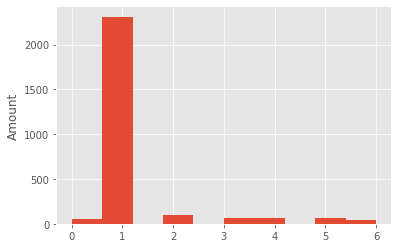

In [90]:
#Distribution of lables
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline
x = kmeans.labels_
plt.hist(x)
plt.ylabel('Amount');

In [91]:
kmeans.labels_

array([1, 1, 3, ..., 1, 1, 1])

In [92]:
print(Counter(x).keys()) 
print(Counter(x).values())

dict_keys([1, 3, 6, 4, 2, 5, 0])
dict_values([2311, 61, 42, 69, 101, 65, 59])


Text(0, 0.5, 'Amount')

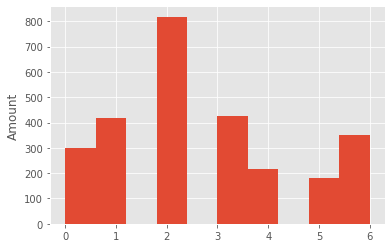

In [93]:
#How the real labels are distributed
x = data.labels
plt.style.use('ggplot')
plt.hist(x)
plt.ylabel('Amount')

In [94]:
print(Counter(x).keys()) 
print(Counter(x).values())

dict_keys([2, 5, 4, 3, 6, 1, 0])
dict_values([818, 180, 217, 426, 351, 418, 298])


In [95]:
import performance as pf

In [96]:
pf.rand_score(data.labels,kmeans.labels_)

0.01564217249891633

In [97]:
pf.mutual_info_score(data.labels,kmeans.labels_)

0.1697281367961051

In [86]:
pf.variation_of_information_score(data.labels,kmeans.labels_)

2.048836961606935